In [69]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#To scale the data using z-score 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

#Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#To tune the model
from sklearn.model_selection import GridSearchCV

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

from nltk.stem.snowball import SnowballStemmer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [2]:
# loading datasets

train = pd.read_csv("game_train.csv")
test = pd.read_csv("game_test.csv")

In [3]:
target = 'user_suggestion'
X = train.drop([target], axis = 1)
y = train[target].values

In [4]:
#Splitting the data into train and test sets
X_train,X_cv,y_train,y_cv=train_test_split(X, y, test_size=0.20, random_state=1 , stratify=y)

In [5]:
train.head()

,review_id,title,year,user_review,user_suggestion
0,473,Sakura Clicker,2017.0,This has helped me through my stage 8 terminal...,1
1,22971,Crusaders of the Lost Idols,2017.0,Awesome idea. I support this game. I love that...,1
2,18225,RaceRoom Racing Experience,2014.0,"This game is just, such a♥♥♥♥♥♥take. The devel...",0
3,17132,Black Squad,2018.0,Early Access Reviewhere what i honesty think a...,1
4,8103,DCS World Steam Edition,2014.0,Very detailed sim and a joy to fly using a fli...,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10494 entries, 0 to 10493
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        10494 non-null  int64  
 1   title            10494 non-null  object 
 2   year             10386 non-null  float64
 3   user_review      10494 non-null  object 
 4   user_suggestion  10494 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 410.0+ KB


In [7]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train["user_review"])
X_train_counts.shape

(8395, 35237)

In [8]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(8395, 35237)

In [9]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [10]:
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])

In [11]:
text_clf = text_clf.fit(X_train["user_review"], y_train)

In [12]:
#function to print classification report and get confusion matrix in a proper format

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

              precision    recall  f1-score   support

           0       0.98      0.62      0.76      3606
           1       0.78      0.99      0.87      4789

    accuracy                           0.83      8395
   macro avg       0.88      0.80      0.81      8395
weighted avg       0.86      0.83      0.82      8395



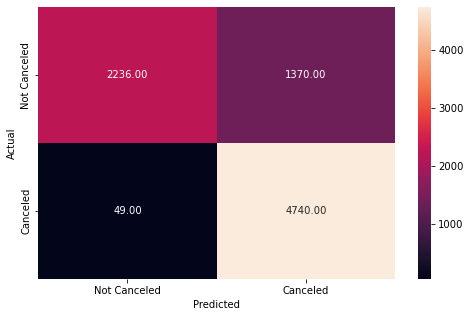

In [13]:
# Checking performance on the training data
y_pred_train = text_clf.predict(X_train["user_review"])
metrics_score(y_train,y_pred_train)

              precision    recall  f1-score   support

           0       0.92      0.44      0.60       902
           1       0.70      0.97      0.81      1197

    accuracy                           0.74      2099
   macro avg       0.81      0.71      0.70      2099
weighted avg       0.79      0.74      0.72      2099



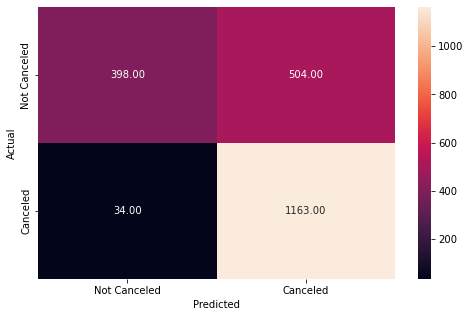

In [14]:
# Checking performance on the training data
y_pred_train = text_clf.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)

In [15]:
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, random_state=42)),
])
_ = text_clf_svm.fit(X_train["user_review"], y_train)

              precision    recall  f1-score   support

           0       0.92      0.44      0.60       902
           1       0.70      0.97      0.81      1197

    accuracy                           0.74      2099
   macro avg       0.81      0.71      0.70      2099
weighted avg       0.79      0.74      0.72      2099



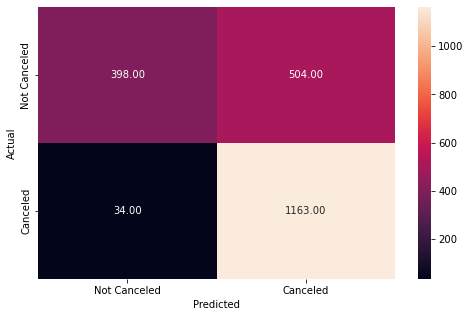

In [16]:
# Checking performance on the training data
y_pred_train = text_clf.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)

In [17]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf__alpha': (1e-2, 1e-3),
}

In [18]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train["user_review"], y_train)

In [19]:
gs_clf.best_score_

0.8544371649791543

In [20]:
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       902
           1       0.85      0.91      0.87      1197

    accuracy                           0.85      2099
   macro avg       0.85      0.84      0.85      2099
weighted avg       0.85      0.85      0.85      2099



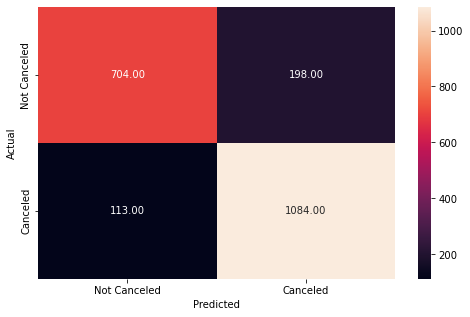

In [21]:
# Checking performance on the training data
y_pred_train = gs_clf.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)

In [22]:
y_test_pred = gs_clf.predict(test["user_review"])
data = {'review_id' : test["review_id"],
       'user_suggestion' : y_test_pred}

pd.DataFrame(data).to_csv('predictions_5.csv', index = False)

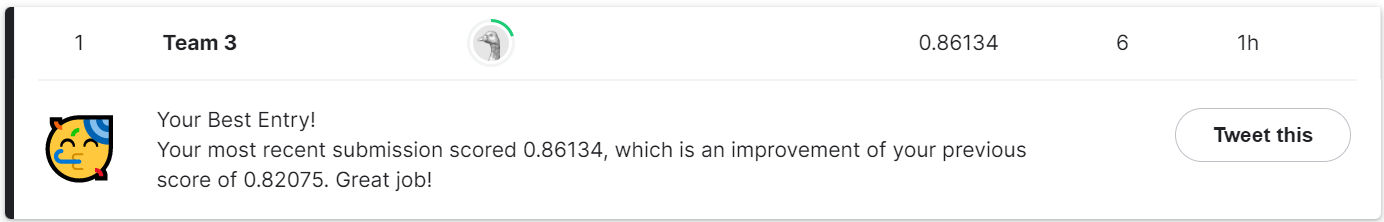

In [23]:
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf-svm__alpha': (1e-2, 1e-3),
 }
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train["user_review"], y_train)
gs_clf_svm.best_score_

0.826801667659321

In [24]:
gs_clf_svm.best_params_

{'clf-svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}

              precision    recall  f1-score   support

           0       0.89      0.72      0.79       902
           1       0.81      0.93      0.87      1197

    accuracy                           0.84      2099
   macro avg       0.85      0.82      0.83      2099
weighted avg       0.85      0.84      0.84      2099



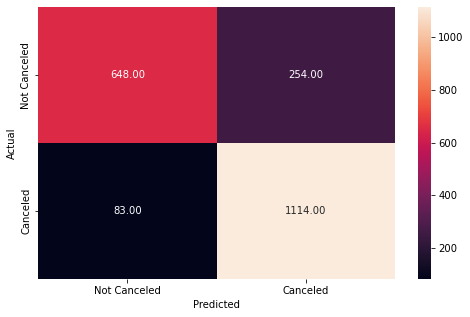

In [25]:
# Checking performance on the training data
y_pred_train = gs_clf_svm.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)

In [26]:
text_clf_2 = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
 ])

In [27]:
gs_clf_2 = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf_2 = gs_clf.fit(X_train["user_review"], y_train)

In [28]:
gs_clf_2.best_score_

0.8544371649791543

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       902
           1       0.85      0.91      0.87      1197

    accuracy                           0.85      2099
   macro avg       0.85      0.84      0.85      2099
weighted avg       0.85      0.85      0.85      2099



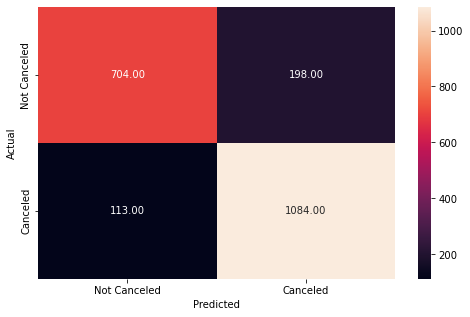

In [29]:
# Checking performance on the training data
y_pred_train = gs_clf_2.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)

In [30]:
import nltk
nltk.download()


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [31]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')
text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect),
                     ('tfidf', TfidfTransformer()),
                      ('mnb', MultinomialNB(fit_prior=False)),
 ])
text_mnb_stemmed = text_mnb_stemmed.fit(X_train["user_review"], y_train)
predicted_mnb_stemmed = text_mnb_stemmed.predict(X_cv["user_review"])
np.mean(predicted_mnb_stemmed == y_cv)

0.8122915674130539

              precision    recall  f1-score   support

           0       0.86      0.68      0.76       902
           1       0.79      0.91      0.85      1197

    accuracy                           0.81      2099
   macro avg       0.82      0.80      0.80      2099
weighted avg       0.82      0.81      0.81      2099



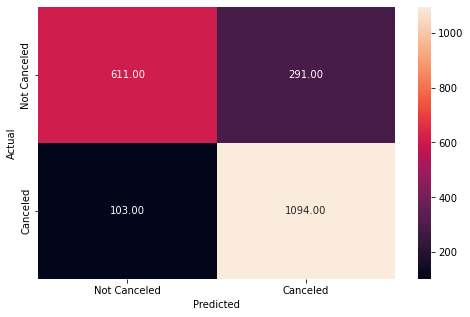

In [32]:
# Checking performance on the training data
y_pred_train = text_mnb_stemmed.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)

In [33]:
rf_0 = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


In [34]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [35]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

random_search = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', RandomForestClassifier()),
])

# Fit the random search model
random_search.fit(X_train["user_review"], y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

              precision    recall  f1-score   support

           0       0.92      0.44      0.60       902
           1       0.70      0.97      0.81      1197

    accuracy                           0.74      2099
   macro avg       0.81      0.71      0.70      2099
weighted avg       0.79      0.74      0.72      2099



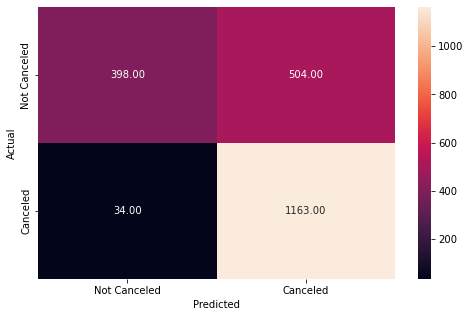

In [36]:
# Checking performance on the training data
y_pred_train = random_search.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)

In [39]:
# Create the parameter grid based on the results of random search 
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)


grid_search_rf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', RandomForestClassifier()),
])

# Fit the random search model
grid_search_rf.fit(X_train["user_review"], y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

              precision    recall  f1-score   support

           0       0.86      0.63      0.73       902
           1       0.77      0.92      0.84      1197

    accuracy                           0.80      2099
   macro avg       0.81      0.78      0.78      2099
weighted avg       0.81      0.80      0.79      2099



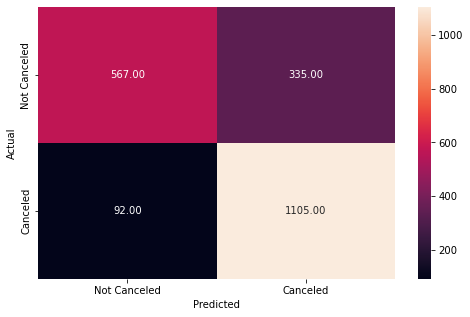

In [41]:
# Checking performance on the training data
y_pred_train = grid_search_rf.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)

In [42]:
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [43]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [56]:
# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search_lrc = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

random_search_lrc = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', LogisticRegression()),
])

# Fit the random search model
random_search_lrc.fit(X_train["user_review"], y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())])

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       902
           1       0.85      0.90      0.87      1197

    accuracy                           0.85      2099
   macro avg       0.85      0.84      0.85      2099
weighted avg       0.85      0.85      0.85      2099



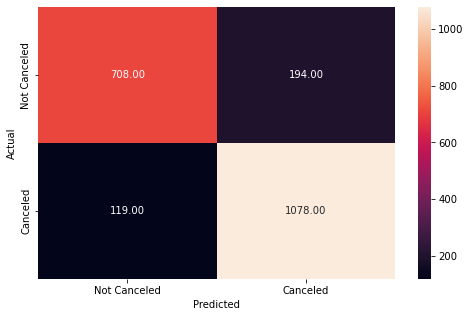

In [57]:
# Checking performance on the training data
y_pred_train = random_search_lrc.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)

In [58]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search_lrc = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search_lrc = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', LogisticRegression()),
])

# Fit the random search model
grid_search_lrc.fit(X_train["user_review"], y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())])

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       902
           1       0.85      0.90      0.87      1197

    accuracy                           0.85      2099
   macro avg       0.85      0.84      0.85      2099
weighted avg       0.85      0.85      0.85      2099



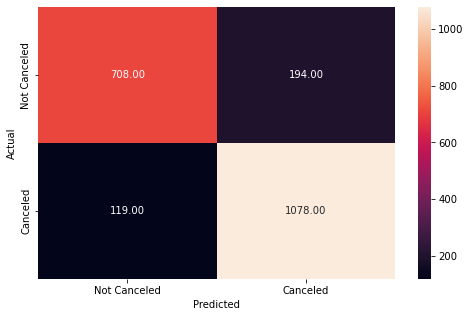

In [59]:
# Checking performance on the training data
y_pred_train = grid_search_lrc.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)

In [52]:
gb_0 = GradientBoostingClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(gb_0.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 8,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [53]:
# n_estimators
n_estimators = [200, 800]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [10, 40]
max_depth.append(None)

# min_samples_split
min_samples_split = [10, 30, 50]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# learning rate
learning_rate = [.1, .5]

# subsample
subsample = [.5, 1.]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample}

pprint(random_grid)

{'learning_rate': [0.1, 0.5],
 'max_depth': [10, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [10, 30, 50],
 'n_estimators': [200, 800],
 'subsample': [0.5, 1.0]}


In [60]:
# First create the base model to tune
gbc = GradientBoostingClassifier(random_state=8)

# Definition of the random search
random_search_gbc = RandomizedSearchCV(estimator=gbc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

random_search_gbc = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', GradientBoostingClassifier()),
])

# Fit the random search model
random_search_gbc.fit(X_train["user_review"], y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier())])

              precision    recall  f1-score   support

           0       0.79      0.61      0.69       902
           1       0.75      0.88      0.81      1197

    accuracy                           0.76      2099
   macro avg       0.77      0.74      0.75      2099
weighted avg       0.77      0.76      0.76      2099



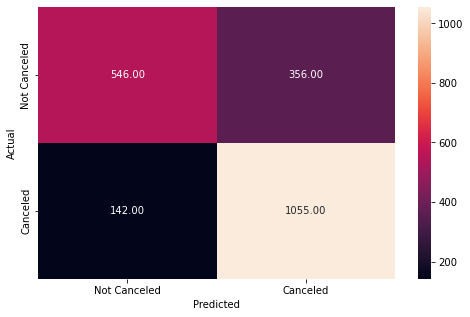

In [61]:
# Checking performance on the training data
y_pred_train = random_search_gbc.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)

In [62]:
# Create the parameter grid based on the results of random search 
max_depth = [5, 10, 15]
max_features = ['sqrt']
min_samples_leaf = [2]
min_samples_split = [50, 100]
n_estimators = [800]
learning_rate = [.1, .5]
subsample = [1.]

param_grid = {
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample

}

# Create a base model
gbc = GradientBoostingClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gbc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search_gbc = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', GradientBoostingClassifier()),
])

# Fit the random search model
grid_search_gbc.fit(X_train["user_review"], y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier())])

              precision    recall  f1-score   support

           0       0.79      0.61      0.69       902
           1       0.75      0.88      0.81      1197

    accuracy                           0.76      2099
   macro avg       0.77      0.74      0.75      2099
weighted avg       0.77      0.76      0.76      2099



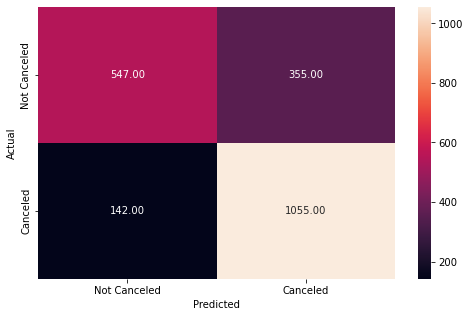

In [63]:
# Checking performance on the training data
y_pred_train = grid_search_gbc.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)

In [70]:
#!pip install xgboost
from xgboost import XGBClassifier

# Checking performance on the cross validation data data
grid_values = {'gamma': [0, 0.1, 0.2 , 0.3, 0.4], 
               'n_estimators': range(60, 200, 40)
               ,'learning_rate':[0.15,0.2,0.25,0.3,0.35]} #'max_depth': np.arange(3,8)}
xgb_best = GridSearchCV(XGBClassifier(tree_method='gpu_hist'), 
                        param_grid=grid_values , 
                        scoring = 'f1_weighted' ,
                        verbose=2,
                        cv=5)
xgb_best = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', XGBClassifier()),
])

# Fit the random search model
xgb_best.fit(X_train["user_review"], y_train)

[00:05:21] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               v

              precision    recall  f1-score   support

           0       0.81      0.76      0.79       902
           1       0.83      0.87      0.85      1197

    accuracy                           0.82      2099
   macro avg       0.82      0.82      0.82      2099
weighted avg       0.82      0.82      0.82      2099



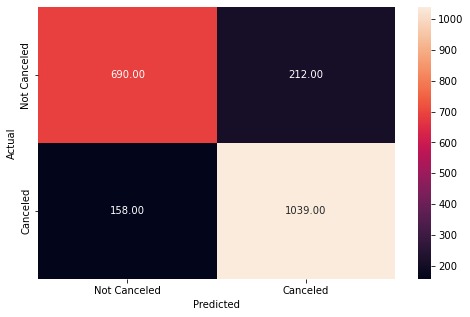

In [71]:
# Checking performance on the training data
y_pred_train = xgb_best.predict(X_cv["user_review"])
metrics_score(y_cv,y_pred_train)